In [1]:
from pennylane import qaoa
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

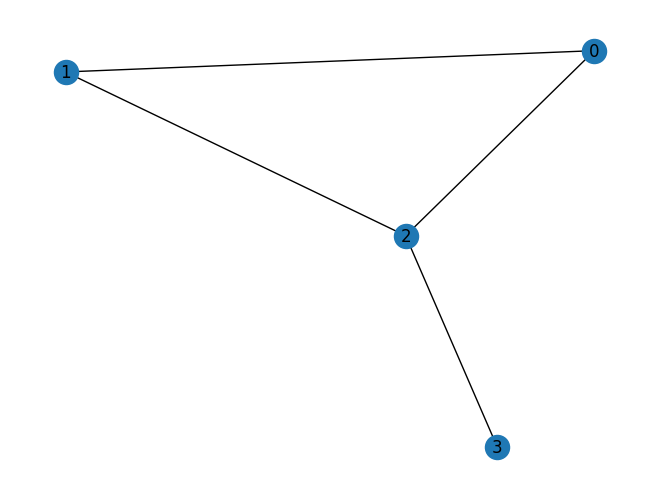

In [2]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [3]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [4]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [5]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [6]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [7]:
from functools import partial

dev = qml.device("default.qubit", wires=4, shots=100)

#@partial(qml.cut_circuit, auto_cutter=True)  # auto_cutter enabled
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)


for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step", i, "Cost", cost_function(params))

print("Optimal Parameters")
print(params)

Step 0 Cost 1.4700000000000002
Step 1 Cost 0.71
Step 2 Cost -0.19999999999999998
Step 3 Cost -0.4
Step 4 Cost -0.55
Step 5 Cost -0.45
Step 6 Cost -0.6799999999999999
Step 7 Cost -0.9400000000000002
Step 8 Cost -1.24
Step 9 Cost -1.27
Step 10 Cost -1.0
Step 11 Cost -1.07
Step 12 Cost -1.4
Step 13 Cost -1.35
Step 14 Cost -1.3
Step 15 Cost -1.5
Step 16 Cost -1.6600000000000004
Step 17 Cost -1.5099999999999998
Step 18 Cost -1.5900000000000003
Step 19 Cost -1.3399999999999999
Step 20 Cost -1.2899999999999998
Step 21 Cost -1.2400000000000002
Step 22 Cost -1.8699999999999999
Step 23 Cost -1.7499999999999998
Step 24 Cost -1.34
Step 25 Cost -1.7799999999999998
Step 26 Cost -1.46
Step 27 Cost -1.7100000000000002
Step 28 Cost -1.4500000000000002
Step 29 Cost -1.6800000000000002
Step 30 Cost -1.59
Step 31 Cost -1.65
Step 32 Cost -1.41
Step 33 Cost -1.9800000000000004
Step 34 Cost -2.01
Step 35 Cost -1.6300000000000001
Step 36 Cost -1.6700000000000002
Step 37 Cost -1.7399999999999998
Step 38 Cost -

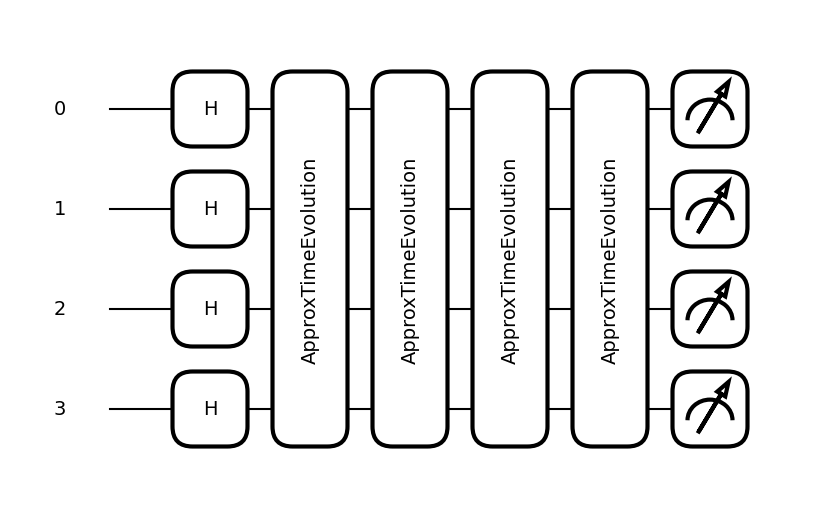

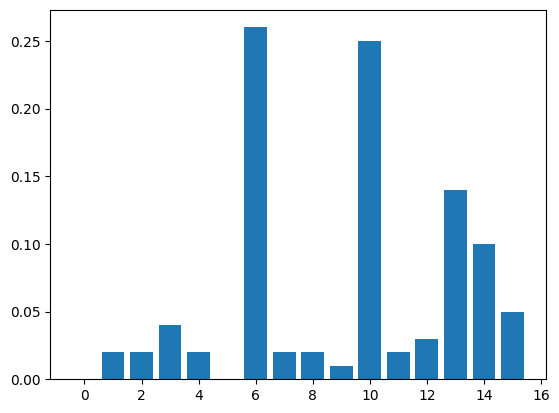

In [8]:
dev = qml.device("default.qubit", wires=wires, shots=100)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])
qml.draw_mpl(probability_circuit)(params[0], params[1])
plt.show()
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [11]:
from functools import partial

steps = 10
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

dev = qml.device("lightning.qubit", wires=3, shots=5)

@partial(qml.cut_circuit, auto_cutter=True, use_opt_einsum=True)
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

qml.specs(cost_function)(params)


for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step", i, "Cost", cost_function(params))

print("Optimal Parameters")
print(params)

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (53).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")
/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (52).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


Step 0 Cost 3.182000000000002
Step 1 Cost 7.169
Step 2 Cost 4.751499999999998
Step 3 Cost -6.149499999999998
Step 4 Cost 11.508
Step 5 Cost -1.213499999999999
Step 6 Cost 5.157999999999996
Step 7 Cost 8.129999999999999
Step 8 Cost -12.962
Step 9 Cost -5.803000000000002
Optimal Parameters
[[ 2.2882275   0.57188375]
 [-0.00484    -0.161725  ]]


In [ ]:

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step", i, "Cost", cost_function(params))

print("Optimal Parameters")
print(params)

In [ ]:
from functools import partial

n_qubit = 4

dev = qml.device("default.qubit", wires=4, shots=1000)

@partial(qml.cut_circuit_mc, auto_cutter=True)  # auto_cutter enabled
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.sample(wires=wires)

res = probability_circuit(params[0], params[1])

bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]

probs = []

str_res = []

for r in res:
    str_res.append("".join([str(int(i)) for i in r]))

for b in bitstrings:
    probs.append(str_res.count(b) / len(res))

print(f"Probability of measuring each state: {probs}")
plt.bar(range(2 ** n_qubit), probs)

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (55).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


KeyboardInterrupt: 